In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")
import requests                 # allows us to dl a webpage
from bs4 import BeautifulSoup   # allows us to scrape html
#import pdb 
# pdb.set_trace() use this for debugging. 
# You will need to exit by writing continue however

from networkx_viewer import Viewer

In [2]:
class AddressLibrary:
    def __init__(self):
        self.addrs = {}
        
    def containsAddr(self, addrNode):
        if addrNode.address in self.addrs:
            return True
        else:
            return False
        
    def addAddr(self, addrNode):
        if addrNode.address in self.addrs:
            rsp = input("Address already exists. Overwrite? [y or n]").lower()
            if rsp == "n":
                return
            else:
                self.addrs[addrNode.address] = addrNode
            
class AddressNode:
    # address = bitcoin address
    # txs = list of transaction objects
    # balance = current financial balance
    def __init__(self, addr, name, args = {}):
        self.address = addr
        self.name = name
        if "txs" in args:
            self.txs = args[txs]
        if "balance" in args:
            self.balance = args["balance"]
    
class TXNode:
    # source = who sent it
    # destination = recipent
    # amount = transaction value
    def __init__(self, txid = "", src = "", dest = "", amt = 0, date = ""):
        self.txid = txid
        self.source = src
        self.destination = dest
        self.amount = amt
        self.date = date
    
    def visualize(self):
        print("---------------")
        print("Transaction " + self.txid)
        print("from: " + self.source)
        print("to: " + self.destination)
        print("occuring at: " + self.date)
        print("of value: " + str(self.amount))
        
def processTX(currentAddr, date, amt, txid):
    if amt[0] == "+":
        #src = getSrcFromTXID(txid)
        src = getNotMappyAddrsFromTxid(txid)[0]
        tx = TXNode(txid, src, currentAddr, float(amt[1:]), date)
        return tx
    if amt[0] == "-":
        #dest = getDestFromTXID(txid)
        dest = getNotMappyAddrsFromTxid(txid)[0]
        tx = TXNode(txid, currentAddr, dest, float(amt[1:]), date)
        return tx
    else:
        print("this is not a valid transaction, value is neither + or -")
        return None

In [3]:
WALLET_EX = "https://www.walletexplorer.com/"
mappy = "1MMaU5nTrFdPZotfwdbv1wWnFjLCTFbpPY" #AddressNode("1MMaU5nTrFdPZotfwdbv1wWnFjLCTFbpPY", "mappy")

mappys_transactions = requests.get(WALLET_EX + "address/" + mappy).content
mappys_transactions_content = BeautifulSoup(mappys_transactions, 'html.parser')
#print(mappys_transactions_content.prettify())
mtc = mappys_transactions_content

In [4]:
# THIS IS A HACKY SOLUTION, NOT LONG-TERM
# (the tables on the transaction page aren't labeled, so for now I am just grabbing
# the first address I see that is not mappy. This will work for transactions that
# only involve 2 parties (some have more), but still makes me cringe a bit
def getNotMappyAddrsFromTxid(txid):
    page = requests.get(WALLET_EX + "txid/" + txid).content
    content = BeautifulSoup(page, 'html.parser')
    table = content.select('table')[1]
    links = [a.get_text() for a in content.select('table')[1].find_all("a")]
    addrs = [link for link in links if len(link) == 34 and link != mappy]
    #print(addrs)
    return addrs
getNotMappyAddrsFromTxid("2c44195149bbc0cf9f8aaeb5e434b899611e7e161e0446ab2bf9240287198df5")

['1CptRcXS2UWw43qzps73Dv8UQXCst2meqf']

In [5]:
txs = []
for row in mtc.select('table tr')[1:]:
    date = row.find_all("td", class_ = "date")[0].get_text()
    amt = row.find_all("td", class_ = "amount diff")[0].get_text()
    txid = row.find_all("td", class_ = "txid")[0].get_text()
    balance = row.find_all("td", class_ = "amount")[0].get_text()
    
    tx = processTX(mappy, date, amt, txid)
    txs.append(tx)
for tx in txs:
    tx.visualize()

---------------
Transaction 2c44195149bbc0cf9f8aaeb5e434b899611e7e161e0446ab2bf9240287198df5
from: 1CptRcXS2UWw43qzps73Dv8UQXCst2meqf
to: 1MMaU5nTrFdPZotfwdbv1wWnFjLCTFbpPY
occuring at: 2017-02-06 01:02:47
of value: 0.14915494
---------------
Transaction eef5e0b1f24194402b89d0af40b1964632996414a40600cd73b82db13fe91d95
from: 1G4y5wvakDNyqaQcW2dB7ccm3PXEuctSiG
to: 1MMaU5nTrFdPZotfwdbv1wWnFjLCTFbpPY
occuring at: 2016-11-24 17:36:42
of value: 0.0001
---------------
Transaction 1b1ac78d6f812c6bf80ad5848fb982592af7e48e295396499037177755d17cd1
from: 1MMaU5nTrFdPZotfwdbv1wWnFjLCTFbpPY
to: 165PJMeVkKbqxxXxkN1z1CivmyfxdRcsQP
occuring at: 2016-08-20 21:23:38
of value: 0.92898899
---------------
Transaction 27e4f4629aca12f13097dcf581688a0d5a20157d8c190b177dfa31920bdb090b
from: 1DmgzvwLkj1Y5FK7fuUHYRfiCwGjUvVkRo
to: 1MMaU5nTrFdPZotfwdbv1wWnFjLCTFbpPY
occuring at: 2016-07-07 22:37:48
of value: 0.03593299
---------------
Transaction 2ae8a39f65fbbaf64988976993074569e34a896e040a93f0537715ccfd4ebbde
fro

In [ ]:
Mappy_plot_basic = nx.Graph()
for tx in txs:
    Mappy_plot_basic.add_edge(tx.source, tx.destination)
# matplotlib inline
pos = nx.spring_layout(Mappy_plot_basic)
plt.axis('off')
plt.figure(num=None, figsize=(15, 15), dpi=80)
nx.draw_networkx_nodes(Mappy_plot_basic, pos)
nx.draw_networkx_edges(Mappy_plot_basic, pos)
nx.draw_networkx_labels(Mappy_plot_basic, pos)
print("Haven't gotten labels to work yet but the center node is obviously Mappy,")
print("surrounded by Nodes (listed above) with which he has traded recently")

# interactive
app = Viewer(Mappy_plot_basic, home_node = mappy, levels=1)
app.mainloop()

Haven't gotten labels to work yet but the center node is obviously Mappy,
surrounded by Nodes (listed above) with which he has traded recently


In [88]:
print("just fun with networkx I didnt bother removing")
# G = nx.Graph()
# for i in range(100):
#     G.add_node(i)
#     if i < 50 and i != 0:
#         G.add_edge(i, 2*i)

just fun with networkx I didnt bother removing


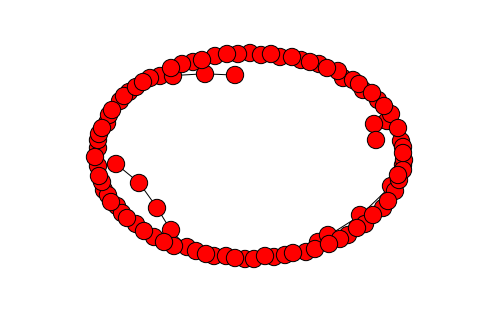

In [26]:
nx.draw(G)

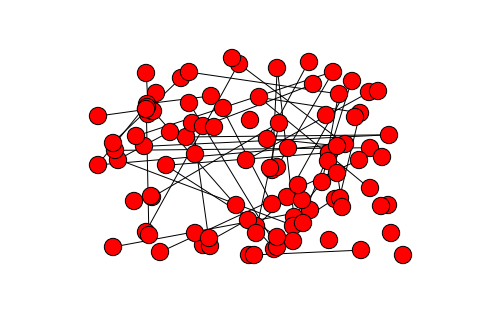

In [27]:
nx.draw_random(G)

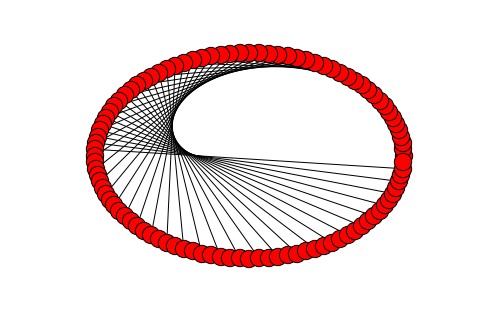

In [28]:
nx.draw_circular(G)

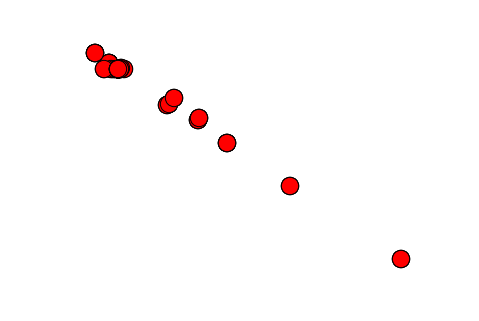

In [29]:
nx.draw_spectral(G)